# Cluster membership probability

Lindegren et al needs to be done

In [119]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: 'Analysis'

# Astrometric solution

Open the file which contains the parameter values for each star in GES

In [ ]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

KeyboardInterrupt: 

# 1.2 Cluster choice

Here choosing open cluster Trumpler 14


In [ ]:
OC=data[data['GES_FLD']=='NGC6705'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in OC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)
set(data['GES_FLD'])

{'134_Tau',
 '18_Sco',
 '25_Ori',
 '32_Gem',
 '67_Oph',
 '68_Tau',
 'Arcturus',
 'Assc50',
 'Blanco1',
 'Br20',
 'Br21',
 'Br22',
 'Br25',
 'Br29',
 'Br30',
 'Br31',
 'Br32',
 'Br36',
 'Br39',
 'Br44',
 'Br73',
 'Br75',
 'Br81',
 'Bulge',
 'Cha_I',
 'Col110',
 'Col197',
 'Col261',
 'Corot',
 'Cz24',
 'Cz30',
 'ESO92_05',
 'GES_MW_00_01',
 'GES_MW_01_02',
 'GES_MW_02_03',
 'GES_MW_03_04',
 'GES_MW_04_05',
 'GES_MW_05_06',
 'GES_MW_06_07',
 'GES_MW_07_08',
 'GES_MW_08_09',
 'GES_MW_09_10',
 'GES_MW_10_11',
 'GES_MW_11_12',
 'GES_MW_12_13',
 'GES_MW_13_14',
 'GES_MW_14_15',
 'GES_MW_15_16',
 'GES_MW_16_17',
 'GES_MW_17_18',
 'GES_MW_18_19',
 'GES_MW_19_20',
 'GES_MW_20_21',
 'GES_MW_21_22',
 'GES_MW_22_23',
 'GES_MW_23_24',
 'GJ205',
 'GJ388',
 'GJ436',
 'GJ526',
 'GJ551',
 'GJ581',
 'GJ699',
 'GJ880',
 'HD102200',
 'HD107328',
 'HD109061',
 'HD122563',
 'HD140283',
 'HD148897',
 'HD163758',
 'HD173819',
 'HD190056',
 'HD204587',
 'HD220009',
 'HD22879',
 'HD24937',
 'HD27271',
 'HD283',


# 1.3 Gaia Data input

Inputting a sample of data in the open cluster region.

In [ ]:
ra=OC['RA'].astype(float)
dec=OC['DEC'].astype(float)
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius
selection_region=gaia_cone(center[0],center[1],radius*0.35)

INFO: Query finished. [astroquery.utils.tap.core]
warning, getting rid of very negaitve parallax


# 1.4 Visualising the sample

The Gaia values are in the higher density regions.

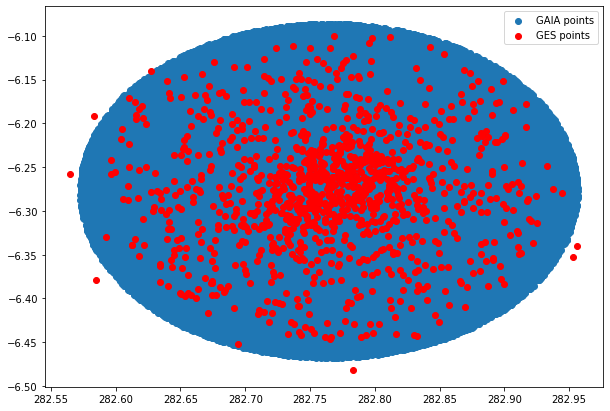

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

# 1.5 Merging dataframes

We want to have a dataframe and if theres a match in GES then that column gets added.

In [ ]:
OC['GAIA_eDR3_ID']=OC['GAIA_eDR3_ID'].astype(int)
selection_region['GAIA_eDR3_ID']=selection_region['source_id']
selection_region

,index,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,GAIA_eDR3_ID
0,0,1636042515805110273,Gaia EDR3 4252444547125365760,4252444547125365760,1537261465,2016.0,282.822155,0.857111,-6.458995,1.048965,...,0,NaN,NaN,NaN,27.161583,-2.907202,283.288754,16.390743,0.190796,4252444547125365760
1,1,1636042515805110273,Gaia EDR3 4252444547125376640,4252444547125376640,1249470614,2016.0,282.821255,0.548207,-6.459160,0.638364,...,0,NaN,NaN,NaN,27.161031,-2.906480,283.287810,16.390661,0.190687,4252444547125376640
2,2,1636042515805110273,Gaia EDR3 4252444577157798016,4252444577157798016,1141889365,2016.0,282.797080,0.450064,-6.462210,0.474097,...,0,NaN,NaN,NaN,27.147395,-2.886458,283.262585,16.389832,0.188021,4252444577157798016
3,4,1636042515805110273,Gaia EDR3 4252444577157817856,4252444577157817856,783401448,2016.0,282.800389,0.289270,-6.458744,0.330574,...,0,NaN,NaN,NaN,27.151982,-2.887816,283.266330,16.392981,0.185212,4252444577157817856
4,5,1636042515805110273,Gaia EDR3 4252444577163896320,4252444577163896320,1500472108,2016.0,282.801197,0.063539,-6.463288,0.084313,...,0,NaN,NaN,NaN,27.148292,-2.890593,283.266728,16.388383,0.189825,4252444577163896320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62814,89339,1636042515805110273,Gaia EDR3 4254020387813208064,4254020387813208064,927688255,2016.0,282.786190,0.449880,-6.087882,0.531068,...,0,NaN,NaN,NaN,27.476418,-2.706903,283.287227,16.763571,0.190324,4254020387813208064
62815,89340,1636042515805110273,Gaia EDR3 4254020387827088512,4254020387827088512,1738943295,2016.0,282.787716,1.336285,-6.089948,1.642496,...,0,NaN,NaN,NaN,27.475266,-2.709192,283.288607,16.761375,0.188451,4254020387827088512
62816,89343,1636042515805110273,Gaia EDR3 4254020387856611968,4254020387856611968,1162122892,2016.0,282.789796,0.066452,-6.088623,0.075015,...,0,NaN,NaN,NaN,27.477387,-2.710433,283.290884,16.762504,0.190028,4254020387856611968
62817,89344,1636042515805110273,Gaia EDR3 4254020387856615680,4254020387856615680,127856892,2016.0,282.786319,0.252010,-6.088186,0.279977,...,0,NaN,NaN,NaN,27.476205,-2.707155,283.287331,16.763256,0.190037,4254020387856615680


In [ ]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(OC['GAIA_eDR3_ID'].astype(int).values)]

In [ ]:
gaia_not_eso=selection_region[~selection_region['GAIA_eDR3_ID'].isin(OC['GAIA_eDR3_ID'].astype(int).values)]

We create two dataframes, one with all of the GAIA ESO values and another which comes from GAIA only.

In [ ]:
gaia_eso=pd.DataFrame.merge(OC, gaia_df_gc,on='GAIA_eDR3_ID')

# 1.6.1 Global corections

Remove G>18
What about the parallax zero point?

https://arxiv.org/pdf/2108.02783.pdf

We use the recommendations from 294 Lindegren et al. (2018) to account for systematics found 295 within the parallax and proper-motion data. In par- 296 ticular, we subtract the -0.029 mas parallax zero-point 297 from all of our stars and exclude all stars fainter than 298 18th Gaia G magnitude.

In [ ]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['phot_g_mean_mag']<=18.0]
gaia_eso=gaia_eso[gaia_eso['phot_g_mean_mag']<=18.0]

In [ ]:
gaia_not_eso

,index,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,GAIA_eDR3_ID
4,5,1636042515805110273,Gaia EDR3 4252444577163896320,4252444577163896320,1500472108,2016.0,282.801197,0.063539,-6.463288,0.084313,...,0,NaN,NaN,NaN,27.148292,-2.890593,283.266728,16.388383,0.189825,4252444577163896320
6,7,1636042515805110273,Gaia EDR3 4252444577181877248,4252444577181877248,87540653,2016.0,282.801584,0.071081,-6.462201,0.089508,...,0,NaN,NaN,NaN,27.149437,-2.890442,283.267231,16.389430,0.188833,4252444577181877248
14,16,1636042515805110273,Gaia EDR3 4252444581485403520,4252444581485403520,421014231,2016.0,282.798533,0.103993,-6.462678,0.114367,...,0,NaN,NaN,NaN,27.147633,-2.887957,283.264038,16.389233,0.188735,4252444581485403520
36,46,1636042515805110273,Gaia EDR3 4252444581556188928,4252444581556188928,428715965,2016.0,282.797903,0.022851,-6.463606,0.025415,...,0,NaN,NaN,NaN,27.146521,-2.887821,283.263300,16.388366,0.189538,4252444581556188928
37,47,1636042515805110273,Gaia EDR3 4252444581556190848,4252444581556190848,430466087,2016.0,282.793986,0.036158,-6.465588,0.035231,...,0,NaN,NaN,NaN,27.142985,-2.885251,283.259071,16.386751,0.190854,4252444581556190848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62798,89320,1636042515805110273,Gaia EDR3 4254019631942354176,4254019631942354176,675266819,2016.0,282.799860,0.016385,-6.089560,0.016968,...,5,5000.0,3.0,0.0,27.481100,-2.719775,283.301201,16.760649,0.190684,4254019631942354176
62799,89321,1636042515805110273,Gaia EDR3 4254019631942354560,4254019631942354560,1351128074,2016.0,282.795044,0.039377,-6.093501,0.041331,...,0,NaN,NaN,NaN,27.475408,-2.717299,283.295843,16.757166,0.185972,4254019631942354560
62804,89326,1636042515805110273,Gaia EDR3 4254019631942363520,4254019631942363520,253577063,2016.0,282.791309,0.056060,-6.090630,0.063529,...,0,NaN,NaN,NaN,27.476281,-2.712685,283.292256,16.760366,0.188245,4254019631942363520
62808,89331,1636042515805110273,Gaia EDR3 4254020383478934912,4254020383478934912,207033174,2016.0,282.787772,0.132970,-6.089009,0.153257,...,0,NaN,NaN,NaN,27.476128,-2.708816,283.288754,16.762304,0.189390,4254020383478934912


# 1.6.2 Proper motion cuts

When making cuts we are going to assume that the GAIA ESO is a 'good' sample and use its values to define the bounds.

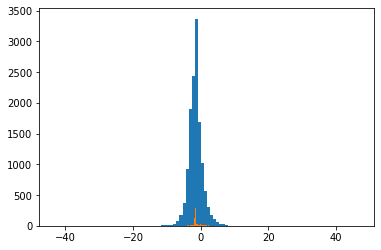

In [ ]:
plt.hist(gaia_not_eso['pmra'],bins=100)
plt.hist(gaia_eso['pmra'],bins=100)
plt.show()

 Make a 3 sigma clip on proper motion

In [ ]:
bound=[gaia_eso['pm'].median()-3*gaia_eso['pm'].std(),gaia_eso['pm'].median()+3*gaia_eso['pm'].std()]

In [ ]:
truth1=gaia_not_eso['pm']>=bound[0]
truth2=gaia_not_eso['pm']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]
len(gaia_not_eso)

12935

In [ ]:
truth1=gaia_eso['pm']>=bound[0]
truth2=gaia_eso['pm']<=bound[1]
gaia_eso=gaia_eso[truth1]
gaia_eso=gaia_eso[truth2]
len(gaia_eso)

979

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

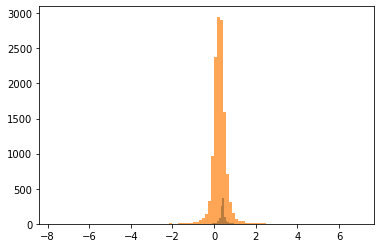

In [ ]:
plt.hist(gaia_eso['parallax'],bins=100)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.7)
plt.show()

In [ ]:
np.std(gaia_eso['parallax'])

0.3653652505379114

In [ ]:
bound=[gaia_eso['parallax'].median()-3*gaia_eso['parallax'].std(),gaia_eso['parallax'].median()+3*gaia_eso['parallax'].std()]

In [ ]:
truth1=gaia_not_eso['parallax']>=bound[0]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]
len(gaia_not_eso)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/3676889474.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


12722

In [ ]:
truth1=gaia_eso['parallax']>=bound[0]
truth2=gaia_eso['parallax']<=bound[1]
gaia_eso=gaia_eso[truth1]
gaia_eso=gaia_eso[truth2]
len(gaia_eso)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/2039189.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_eso=gaia_eso[truth2]


969

In [ ]:
gaia_not_eso['parallax'].min()

-0.6881985653324588

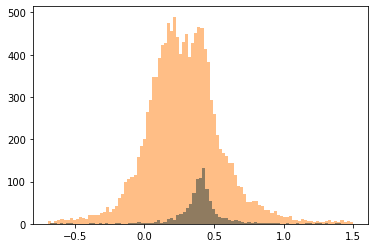

In [ ]:

plt.hist(gaia_eso['parallax'],bins=90)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.5)
plt.show()

Even after the parallax cut of 3 sigma there are still plenty of sources.

After making a very conservative cut we are going to attempt to fit the BNN with error.

# 1.7 Making Data into Learning Format.

In [ ]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']



(array([  5.,   4.,   7.,  29., 265., 570.,  58.,  18.,   5.,   8.]),
 array([-0.67486935, -0.46616237, -0.25745539, -0.04874841,  0.15995857,
         0.36866555,  0.57737252,  0.7860795 ,  0.99478648,  1.20349346,
         1.41220044]),
 <BarContainer object of 10 artists>)

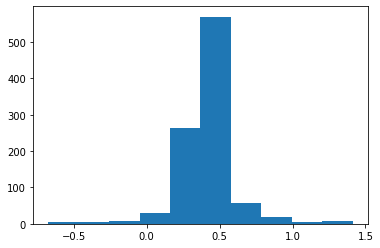

In [ ]:
plt.hist((gaia_eso['parallax'].astype(float)))

The radial velocity of >300 is so massively diferent can I assume to cut it out?

In [ ]:
gaia_eso=gaia_eso[gaia_eso.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]



In [ ]:

data=pd.concat([gaia_eso, gaia_not_eso])
input_cluster_data=data[columns_parameters]
input_cluster_data


,ra,dec,parallax,VRAD,pmra,pmdec
0,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109
1,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751
2,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408
3,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868
4,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344
...,...,...,...,...,...,...
62798,282.799860,-6.089560,1.103110,NaN,2.171839,-0.896184
62799,282.795044,-6.093501,0.476147,NaN,-3.465083,-5.004739
62804,282.791309,-6.090630,0.068066,NaN,-3.783315,-7.710635
62808,282.787772,-6.089009,0.292921,NaN,-2.149665,-7.440230


In [ ]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([gaia_eso, gaia_not_eso])[columns_error]

# Covariance Error matrix

In [ ]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

This follows the paper linked later. The matrix R I use is a diagonal matrix with 1 in the nth position if we have a data reading for the nth feature, and zero otherwise.

For the moment we don't need it to be very complex as we are going to only have two different cases, i.e whether or not a value has radial velocity. 

In [ ]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [ ]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)

# Definitions of the learning inputs

In [ ]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix
learning_R=R


# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In this section I'm following the above paper which adapts the GMM to noisy and missing data. I only apply this to the Gaia eso data at first, and using astrometric data.

Using Bayes Law:
$$ P(C | D)= P(D|C)P(C)\over{P(D)}$$
Let $\textbf{w}_{i}$ be the vector of observed data, and $\textbf{x}_i$ be the vector of 'true' values. Let $R$ be the matrix which projects $\textbf{x}_i$ to $\textbf{w}_i$ and let $S_i$ be a known covariance matrix, so that we assume $$\textbf{w}_i=R_i\textbf{x}_i + \text{noise}$$ where the noise is drawn from a Gaussian distribution with mean 0 and covariance $S_i$

Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [ ]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Analysis')

In [ ]:
%load_ext autoreload
%autoreload 2

# We are only using the Data which is in Gaia Eso and some of the Gaia data now as we have a few bugs to fix.

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

One part uses all the GES data and other uses both Gaia eso and gaia.

In [ ]:
gmm_GES=XDGMM(2).fit(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

gmm_full=XDGMM(3).fit(learning_input,Xerr=learning_error_covariance,R=R)

gmm
endgmm
gmm
endgmm


# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$


The prior is $p(z=i|\theta)=\alpha_i$. This is the posterior probability that an observation has been generated from the $i^{th}$ component

Just Using Gaia ESO Data

In [ ]:

prob_ges=gmm_GES.prob_z_given_w(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

Plotting

In [ ]:
df=pd.DataFrame(learning_input[0:len(gaia_eso)],columns=columns_parameters)
df2=pd.DataFrame(prob_ges[:,0][0:len(gaia_eso)],columns=['prob'])
plot_df_ges=pd.concat([df,df2],axis=1)
plot_df_ges

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,1.631699e-04
1,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,3.672494e-263
2,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,7.177857e-43
3,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868,6.417519e-85
4,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344,1.090858e-53
...,...,...,...,...,...,...,...
964,282.924777,-6.282666,0.578974,0.77,1.227842,-0.355204,1.221550e-209
965,282.925362,-6.313343,0.681330,32.77,-1.763939,-4.189295,9.881336e-01
966,282.933178,-6.248270,0.518017,18.74,1.297329,2.485403,0.000000e+00
967,282.937478,-6.275078,0.424426,35.36,-1.555129,-4.222299,9.998171e-01


In [ ]:
sum(plot_df_ges[0:len(gaia_eso)]['prob']>=0.99)

468

Just training and evaluating on the original sample gives 400 members with probability >=0.99

We not plot these values vs their membership.

# GAIA ESO Train and evaluate.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

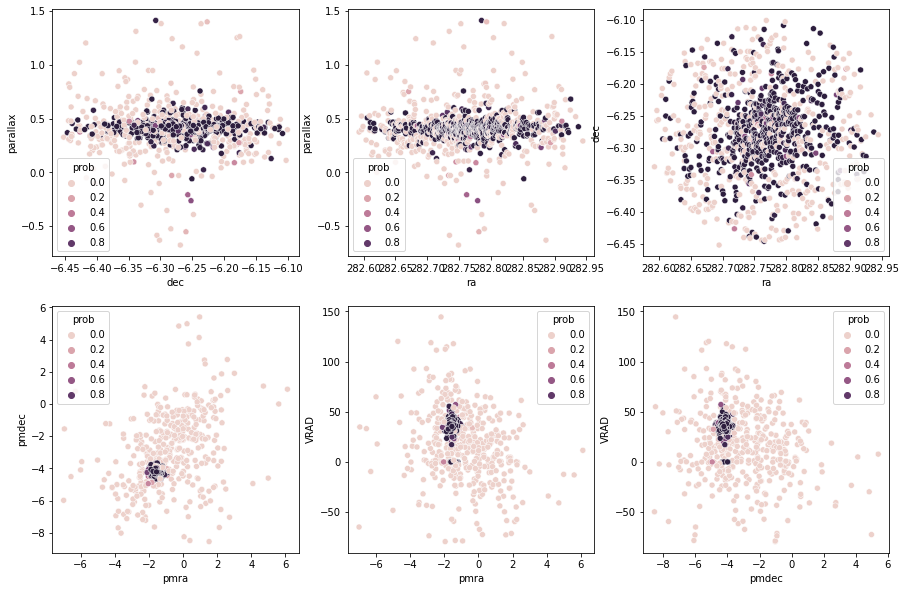

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_ges,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_ges,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_ges,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_ges,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_ges,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_ges,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# GAIA ESO and GAIA Train and evaluate.

This is a 3 compoennt GMM

In [ ]:

prob_full=gmm_full.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(prob_full[:,1],columns=['prob'])
plot_df_full=pd.concat([df,df2],axis=1)
plot_df_full


,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,1.401557e-04
1,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,8.688848e-296
2,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,1.092774e-51
3,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868,6.124245e-84
4,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344,3.829929e-61
...,...,...,...,...,...,...,...
13686,282.799860,-6.089560,1.103110,0.00,2.171839,-0.896184,1.159803e-283
13687,282.795044,-6.093501,0.476147,0.00,-3.465083,-5.004739,4.286458e-39
13688,282.791309,-6.090630,0.068066,0.00,-3.783315,-7.710635,8.270436e-145
13689,282.787772,-6.089009,0.292921,0.00,-2.149665,-7.440230,3.861684e-59


In [ ]:
sum(plot_df_full[0:len(gaia_eso)]['prob']>=0.99)

435

Now there are only 300 objects in the original GES sample which are identified as being part of the cluster, this is verified by the following plots.

GAIA ESO AND GAIA

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

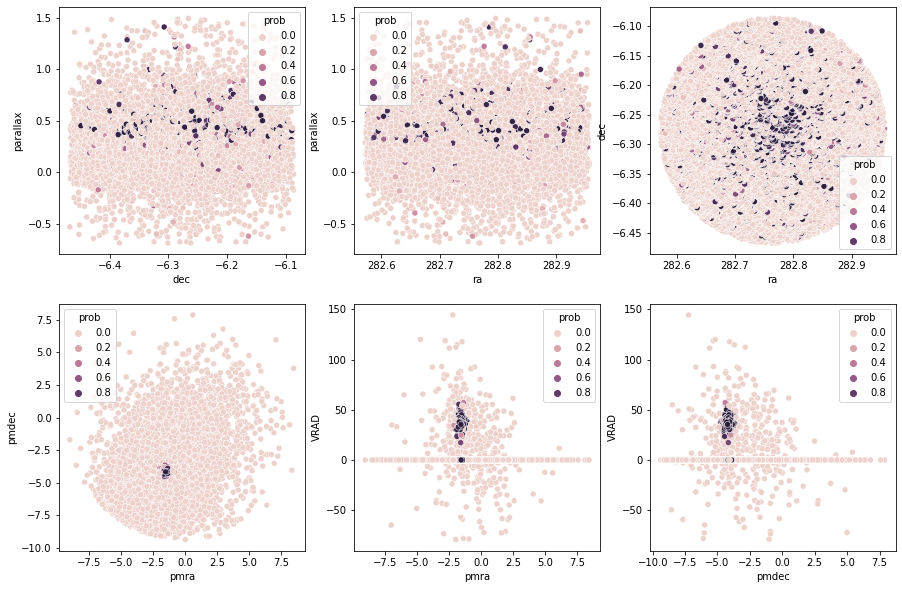

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_full,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_full,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_full,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_full,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_full,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_full,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# 2.2 Train on Gaia ESO and evaluate on GAIA plus GAIA ESO

We now see what happens if we train on a 'good' sample, that being the GAIA ESO and then apply to a much larger data set, with also less information attached to it.

In [ ]:

comp=gmm_GES.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,0],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,1.631699e-04
1,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,3.672494e-263
2,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,7.177857e-43
3,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868,6.417519e-85
4,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344,1.090858e-53
...,...,...,...,...,...,...,...
13686,282.799860,-6.089560,1.103110,0.00,2.171839,-0.896184,1.948819e-294
13687,282.795044,-6.093501,0.476147,0.00,-3.465083,-5.004739,1.071112e-36
13688,282.791309,-6.090630,0.068066,0.00,-3.783315,-7.710635,2.936584e-139
13689,282.787772,-6.089009,0.292921,0.00,-2.149665,-7.440230,1.802676e-57


In [ ]:
sum(plot_df[0:len(gaia_eso)]['prob']>=0.99)

468

As we expect this gives us the same number of members >=0.99 probability from the Gaia_eso sample

Now we see this evaluated on our full dataset.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

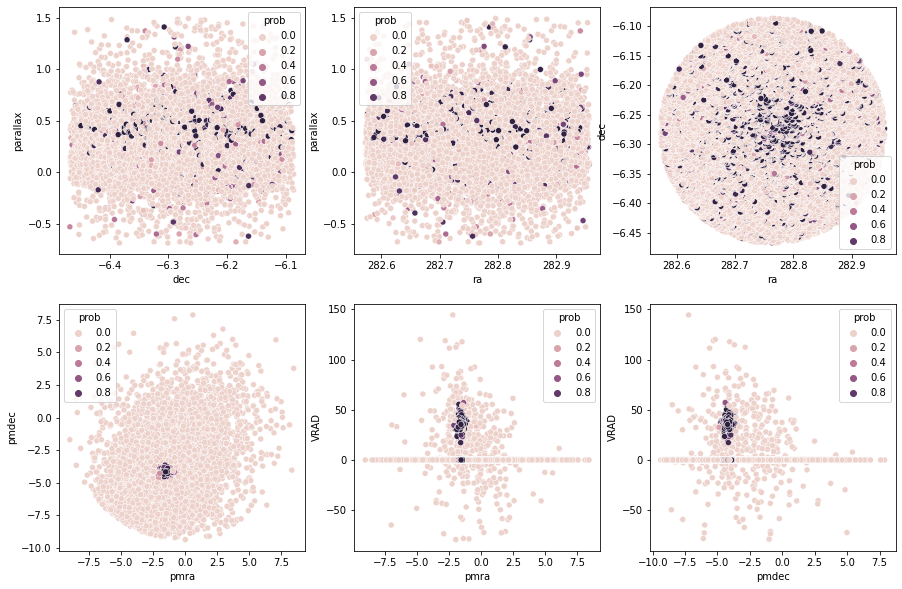

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Now we evaluate it only on the GAIA data

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

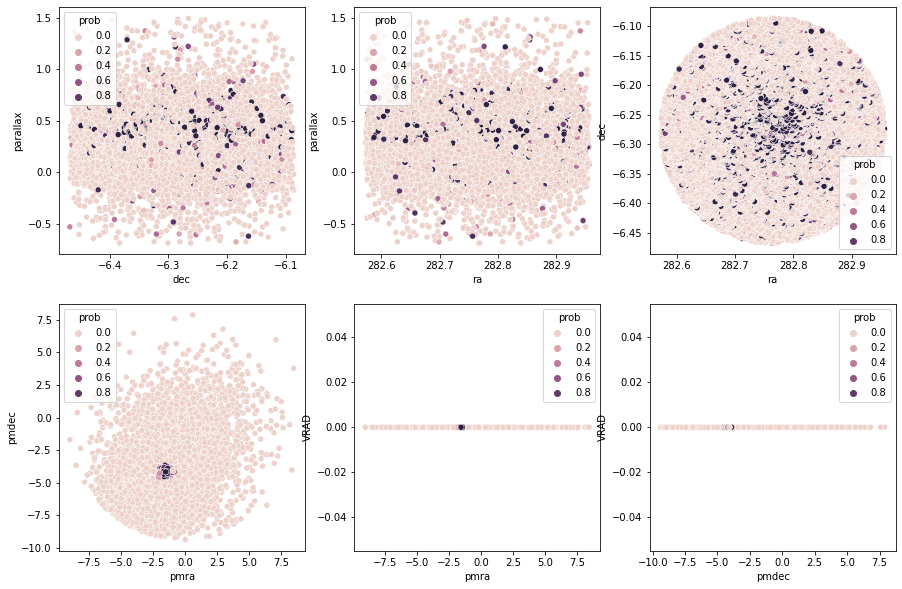

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Colour Magnitude Diagrams

https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

In [ ]:
df_diagram=pd.concat([plot_df.reset_index(),data[['bp_rp','phot_g_mean_mag','bp_g','g_rp']].reset_index()],axis=1)
df_diagram_full=pd.concat([plot_df_full.reset_index(),data[['bp_rp','phot_g_mean_mag','bp_g','g_rp']].reset_index()],axis=1)

In [ ]:
data_for_hr1=df_diagram[df_diagram['prob']>=0.9]
data_for_hr2=df_diagram[df_diagram['prob']<0.9]

In [ ]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']+5*np.log10((selection_gaia['parallax'])/1000.0)+5
    return selection_gaia

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/2920233484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']+5*np.log10((selection_gaia['parallax'])/1000.0)+5
/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/2920233484.py:3: SettingWi

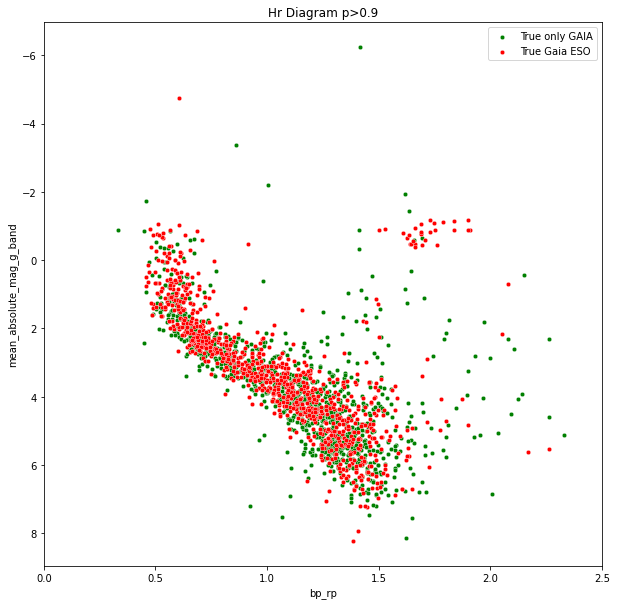

In [ ]:

f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=mean_basolute_mag_g_band(data_for_hr1[len(gaia_eso):])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=20,color='g')

scatter=mean_basolute_mag_g_band(data_for_hr1[:len(gaia_eso)])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=20,color='r')

scatter=mean_basolute_mag_g_band(data_for_hr2)
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram p>0.9")
plt.show()

# Plot using what was trained on all of the data.

In [ ]:
data_for_hr1_full=df_diagram_full[df_diagram_full['prob']>=0.9]
data_for_hr2_full=df_diagram_full[df_diagram_full['prob']<0.9]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/2920233484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']+5*np.log10((selection_gaia['parallax'])/1000.0)+5
/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_2953/2920233484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

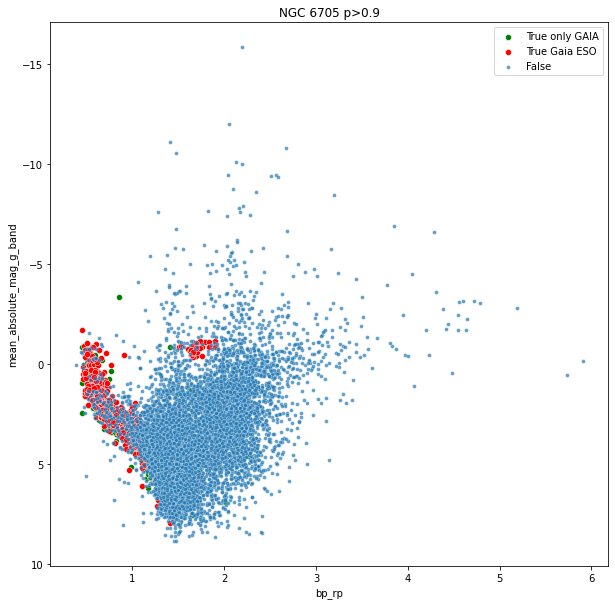

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=mean_basolute_mag_g_band(data_for_hr1_full[len(gaia_eso):])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',color='g')

scatter=mean_basolute_mag_g_band(data_for_hr1_full[:len(gaia_eso)])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',color='r')

scatter=mean_basolute_mag_g_band(data_for_hr2)
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

See jackson paper for comparison. Using the three component one with all of the data is good.

# Posterior.
https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

# Using Variational Autoencoders to reduce the dimensions of the HR diagram

In [ ]:
data_for_colour_pre=mean_basolute_mag_g_band(df_diagram_full)
data_for_colour=data_for_colour_pre[['bp_rp','mean_absolute_mag_g_band','prob','ra','dec','parallax','VRAD','pmra','pmdec','phot_g_mean_mag','bp_g','g_rp']]

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# eventually will have to include dropna values

In [ ]:
data_for_colour=data_for_colour.dropna()

In [ ]:
data_for_colour

,bp_rp,mean_absolute_mag_g_band,prob,ra,dec,parallax,VRAD,pmra,pmdec,phot_g_mean_mag,bp_g,g_rp
0,1.252724,4.757831,1.401557e-04,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,16.887486,0.575531,0.677193
1,1.342695,4.818810,8.688848e-296,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,16.224398,0.585712,0.756983
2,1.233818,3.866628,1.092774e-51,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,15.882403,0.529069,0.704749
3,1.302891,4.732254,6.124245e-84,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868,16.581614,0.573345,0.729546
4,1.284147,3.542481,3.829929e-61,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344,16.150970,0.513781,0.770367
...,...,...,...,...,...,...,...,...,...,...,...,...
13686,1.830289,1.747909,1.159803e-283,282.799860,-6.089560,1.103110,0.00,2.171839,-0.896184,11.534814,0.897312,0.932977
13687,1.433637,4.185875,4.286458e-39,282.795044,-6.093501,0.476147,0.00,-3.465083,-5.004739,15.797170,0.625474,0.808163
13688,2.430515,0.571882,8.270436e-145,282.791309,-6.090630,0.068066,0.00,-3.783315,-7.710635,16.407227,1.330153,1.100363
13689,1.681990,5.159354,3.861684e-59,282.787772,-6.089009,0.292921,0.00,-2.149665,-7.440230,17.825600,0.691404,0.990585


In [ ]:
from sklearn.preprocessing import  MinMaxScaler
import torch



In [ ]:
scaler=MinMaxScaler()


In [ ]:
colour_mag=scaler.fit_transform(data_for_colour[['bp_rp','mean_absolute_mag_g_band']].values)
colour_mag=data_for_colour[['bp_rp','phot_g_mean_mag','parallax','bp_g','g_rp']].values


# Try with just gaia eso data for now

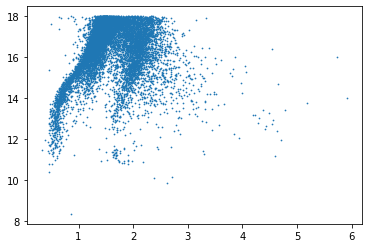

In [ ]:
plt.scatter(colour_mag.transpose()[0],colour_mag.transpose()[1],s=0.5)


# Train the Variational Autoencoders

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 617 #617 #factor for 1090
lr = 1e-3
epochs = 100

In [ ]:
vae_spec=DataLoader(torch.tensor(colour_mag).float(),batch_size=batch_size) 

In [ ]:
zdim=2

In [ ]:
encoder = Encoder(input_dim=colour_mag.shape[1], hidden_dims=[200,200], z_dim=zdim,dropout=0.2)
decoder = Decoder(output_dim=colour_mag.shape[1], hidden_dims = [200,200], z_dim=zdim,dropout=0.2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer=Adam(model.parameters(),lr=lr)

In [ ]:
print("Start training VAE...")
model.train()
model_train(vae_spec=vae_spec,model=model,optimizer=optimizer,loss_function=loss_function,epochs=epochs,batch_size=batch_size)


Start training VAE...
	Epoch 1 complete! 	Average Loss:  45.42217677944355
Overall Loss:  504458.6953125
	Epoch 2 complete! 	Average Loss:  21.250963812494373
Overall Loss:  236013.2041015625
	Epoch 3 complete! 	Average Loss:  11.154446665583356
Overall Loss:  123881.28466796875
	Epoch 4 complete! 	Average Loss:  7.298126632880031
Overall Loss:  81052.99438476562
	Epoch 5 complete! 	Average Loss:  6.61920945304762
Overall Loss:  73512.94018554688
	Epoch 6 complete! 	Average Loss:  5.41941851357093
Overall Loss:  60188.06201171875
	Epoch 7 complete! 	Average Loss:  4.646603257811093
Overall Loss:  51605.17578125
	Epoch 8 complete! 	Average Loss:  4.214075309359102
Overall Loss:  46801.52038574219
	Epoch 9 complete! 	Average Loss:  3.491462464335157
Overall Loss:  38776.18212890625
	Epoch 10 complete! 	Average Loss:  3.0255141022096725
Overall Loss:  33601.359619140625
	Epoch 11 complete! 	Average Loss:  2.4573575732043773
Overall Loss:  27291.413208007812
	Epoch 12 complete! 	Average Lo

In [ ]:
model.eval()
x_recon=model(torch.tensor(colour_mag).float())[0].detach().numpy()

In [ ]:
z_mean=model(torch.tensor(colour_mag).float())[1].detach().numpy()
z_log_var=model(torch.tensor(colour_mag).float())[2].detach().numpy()

z=model(torch.tensor(colour_mag).float())[3].detach().numpy()

# This z is only a sample of $p(z|x)$, the posterior encoder of the latent space given the observations $x$, i.e color_mag. So we need to MCMC on this to get samples.

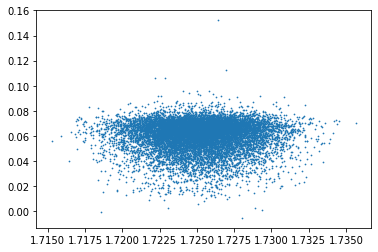

In [ ]:
plt.scatter(model(torch.tensor(colour_mag).float())[0].detach().numpy().transpose()[0],model(torch.tensor(colour_mag).float())[1].detach().numpy().transpose()[0],s=0.5)


In [ ]:
data_for_colour[['z_mean1','z_mean2']]=z_mean
data_for_colour[['z1','z2']]=z


<AxesSubplot:xlabel='z_mean1', ylabel='z_mean2'>

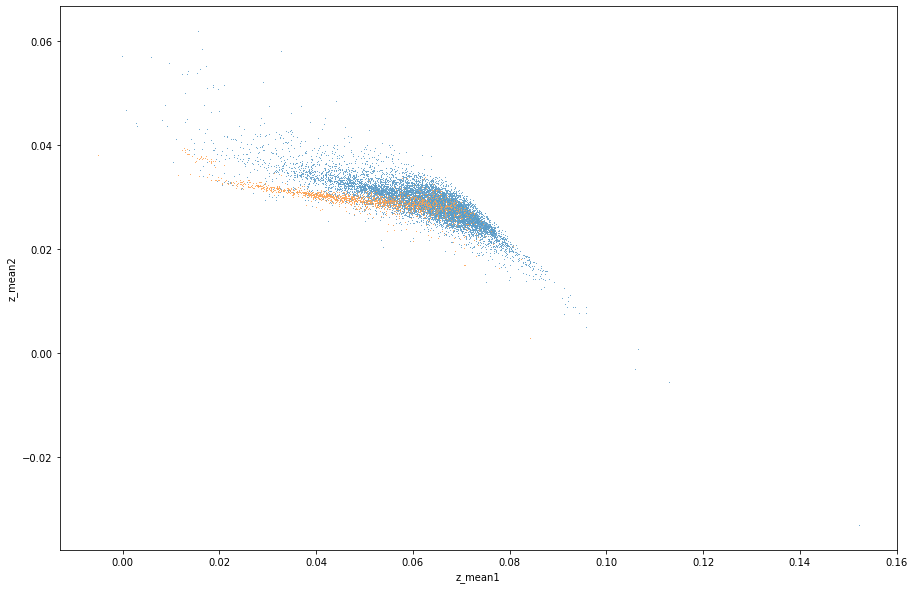

In [ ]:
plt.figure(figsize=(15,10))
sn.scatterplot(data=data_for_colour[data_for_colour['prob']<=0.9],x='z_mean1',y='z_mean2',s=1)
sn.scatterplot(data=data_for_colour[data_for_colour['prob']>0.9],x='z_mean1',y='z_mean2',s=1)

<AxesSubplot:xlabel='z1', ylabel='z2'>

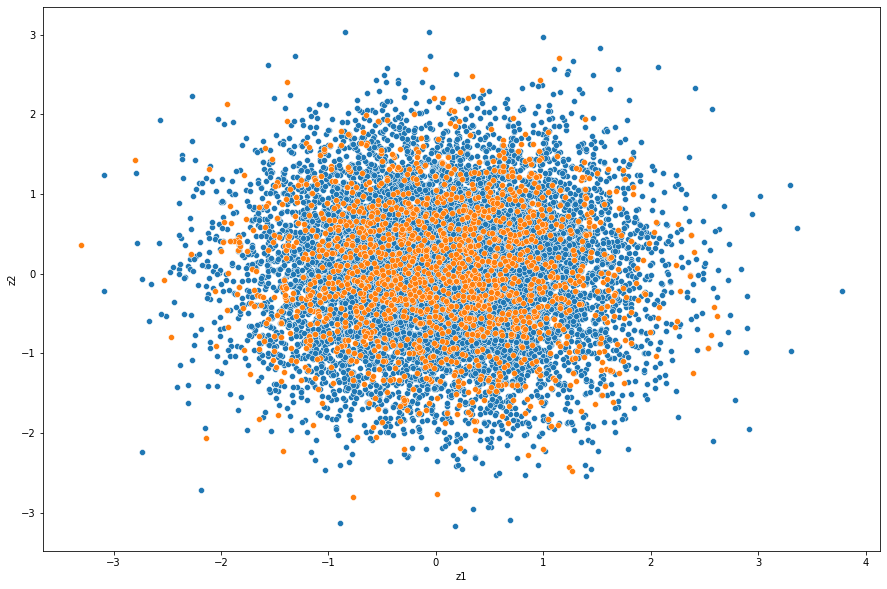

In [ ]:
plt.figure(figsize=(15,10))
sn.scatterplot(data=data_for_colour[data_for_colour['prob']<=0.9],x='z1',y='z2')
sn.scatterplot(data=data_for_colour[data_for_colour['prob']>0.9],x='z1',y='z2')

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=2, random_state=0).fit(data_for_colour[['z1','z2']].values)

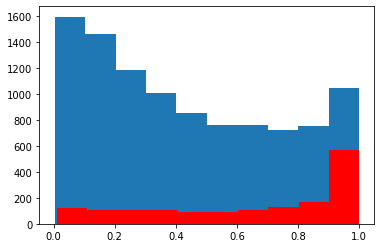

In [ ]:
plt.hist(gm.predict_proba(data_for_colour[data_for_colour['prob']<=0.9][['z1','z2']].values).transpose()[0])
plt.hist(gm.predict_proba(data_for_colour[data_for_colour['prob']>0.9][['z1','z2']].values).transpose()[0],color='r')
plt.show()

In [ ]:
data_for_colour['prob_col']=gm.predict_proba(data_for_colour[['z_mean']].values).transpose()[0]

KeyError: "None of [Index(['z_mean'], dtype='object')] are in the [columns]"

In [ ]:
data_for_colour

,bp_rp,mean_absolute_mag_g_band,prob,ra,dec,parallax,VRAD,pmra,pmdec,phot_g_mean_mag,z_mean1,z_mean2,z_mean3,z_mean,prob_col
0,1.252724,4.757831,1.401074e-04,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,16.887486,1.930296e-04,0.000237,0.000119,0.000101,0.765903
1,1.342695,4.818810,7.038201e-296,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,16.224398,1.805574e-04,0.000129,0.000120,0.000086,0.765901
2,1.233818,3.866628,1.039101e-51,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,15.882403,6.195903e-05,0.000546,0.000087,0.000088,0.765901
3,1.302891,4.732254,6.113354e-84,282.599110,-6.255866,0.426705,39.42,-4.621738,-4.713868,16.581614,1.769960e-04,0.000196,0.000119,0.000092,0.765902
4,1.284147,3.542481,3.665280e-61,282.603911,-6.217897,0.300817,1.19,-1.633921,-2.342344,16.150970,6.407499e-07,0.000603,0.000082,0.000072,0.765900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13686,1.830289,1.747909,1.159343e-283,282.799860,-6.089560,1.103110,0.00,2.171839,-0.896184,11.534814,-4.028231e-04,0.000660,0.000049,-0.000119,0.765881
13687,1.433637,4.185875,4.285806e-39,282.795044,-6.093501,0.476147,0.00,-3.465083,-5.004739,15.797170,6.259978e-05,0.000248,0.000104,0.000054,0.765898
13688,2.430515,0.571882,8.268588e-145,282.791309,-6.090630,0.068066,0.00,-3.783315,-7.710635,16.407227,-7.248372e-04,0.000464,-0.000168,-0.000393,0.765848
13689,1.681990,5.159354,3.861720e-59,282.787772,-6.089009,0.292921,0.00,-2.149665,-7.440230,17.825600,1.496524e-04,-0.000312,0.000031,0.000018,0.765895


# Check colour mag for the colours 

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_24151/699643076.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scatter=data_for_colour[data_for_colour[len(gaia_eso):]['prob_col']<0.8]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

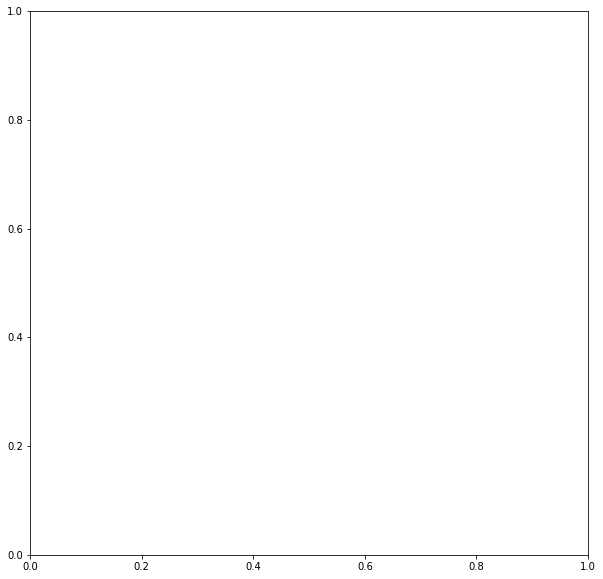

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)


scatter=data_for_colour[data_for_colour['prob_col']>=0.8][:len(gaia_eso)]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',color='r')

scatter=data_for_colour[data_for_colour[len(gaia_eso):]['prob_col']<0.8]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()